In [7]:
%load_ext autoreload
%autoreload 2

from src.models.beacon_model import BeaconModel
from src.models.wifi_model import WifiModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown, get_study
from src.plotting import plot_traces, plot_wifi, plot_beacons

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5a0546857ecc773753327266"
floor_id = "B1"

floor_data = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=True,        
        )

floor_data_wifi = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=False,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full_wifi = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=False,        
        )


floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]
sns.set(style="whitegrid")

train_indices = (~floor_data.test_mask & ~floor_data.validation_mask).nonzero().flatten()
test_indices = floor_data.test_mask.nonzero().flatten()

mini_batch_train = floor_data_full[train_indices[1:17:2]]
mini_batch_test = floor_data_full[test_indices[:8]]

mini_batch_train_wifi = floor_data_full_wifi[train_indices[1:17:2]]
mini_batch_test_wifi = floor_data_full_wifi[test_indices[:8]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Optimized for predictive power
Due to bad performance on infering the location when evaluating the more complicated models (wifi and beacon), we try to choosing the models hyperparameters using `optuna` with a measure on the location predictive performance, 
$$mse = \frac{1}{|I|}\sum_{i \in I} ||\boldsymbol x_i - \boldsymbol{\hat x_i}||$$ 
where the index set $I$ contains the times (and trace id) when $\boldsymbol{\hat x_i}$ in a trace in the test set is observed. 

Optimizing using this mse measure yields the following results on the wifi model and beacon model

In [14]:
wifi_model = WifiModel(floor_data_wifi)
beacon_model = BeaconModel(floor_data)

In [15]:
best_trial_nr = get_study("mse_beacon").best_trial.number
checkpoint = torch.load(f"../checkpoints/beacon_hparam_0{best_trial_nr}.pt", map_location="cpu")
beacon_model.load_state_dict(checkpoint["model_state_dict"])

best_trial_nr_wifi = get_study("mse_wifi").best_trial.number
checkpoint_wifi = torch.load(f"../checkpoints/wifi_hparam_0{best_trial_nr}.pt", map_location="cpu")
wifi_model.load_state_dict(checkpoint_wifi["model_state_dict"])

<All keys matched successfully>

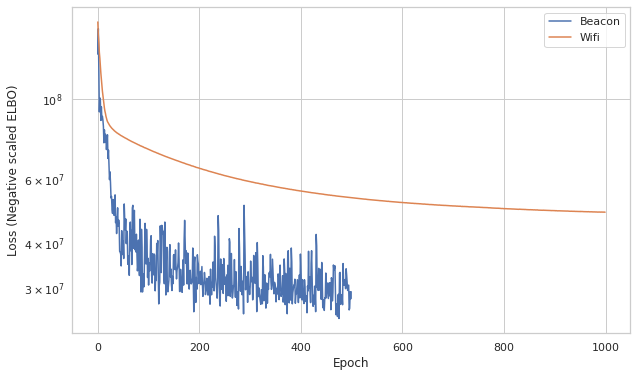

In [16]:
plt.figure(figsize=(10,6))
plt.plot(checkpoint["loss_history"], label = "Beacon")
plt.plot(checkpoint_wifi["loss_history"], label = "Wifi")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")
plt.legend()
plt.show()

### Beacon model

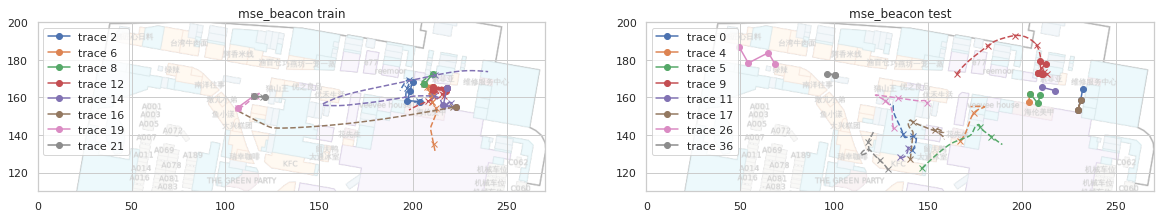

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model, mini_batch_train)
plt.ylim((110, 200))
plt.title("mse_beacon train")
plt.legend()

plt.subplot(122)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(beacon_model, mini_batch_test)
plt.ylim((110, 200))
plt.title("mse_beacon test")
plt.legend()
plt.show()

The hyper parameters are chosen such that the distance of the test traces are as close as possible to the labels $\boldsymbol {\hat x}$. Indeed the test traces are now more close to labels than in notebook 3. However, the performance is still bad.  

### Wifi model

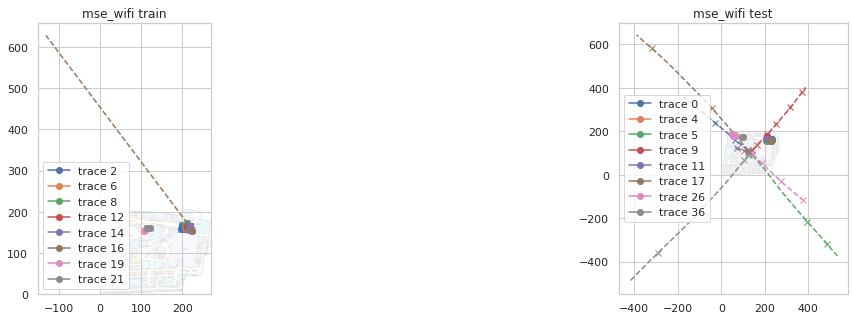

In [30]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(wifi_model, mini_batch_train_wifi)
#plt.ylim((110, 200))
plt.title("mse_wifi train")
plt.legend()

plt.subplot(122)
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(wifi_model, mini_batch_test_wifi)
#plt.ylim((110, 200))
plt.title("mse_wifi test")
plt.legend()
plt.show()

Not succesfull, indeed the mse error for the wifi model, was very high, 